In [78]:
import os
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [79]:
# hdul=fits.open("/home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390254/ni6050390254_cl_night_barycorrmpu7_sr_night.lc")
# hdul[0].header

In [80]:
df=pd.read_csv('all_lc_periods_evt_files_bary_orbit_piexpiex.txt',sep='\t')
df_filtered = df[df['TSTARTI'] != 0]
df_sorted = df_filtered.sort_values(by='TSTARTI').reset_index()
date=df_sorted['TSTARTI']
period=df_sorted['Period']
freq=1000/period

df1=pd.read_csv('all_lc_periods_evt_files_no_correction.txt',sep='\t')
df_sorted1 = df1.sort_values(by='TSTARTI')
date1=df_sorted1['TSTARTI']
period1=df_sorted1['Period']
freq1=1000/period1

df2=pd.read_csv('all_lc_periods_evt_files_bary_orbit.txt',sep='\t')
df_filtered2 = df2[df2['TSTARTI'] != 0]
df_sorted2 = df_filtered2.sort_values(by='TSTARTI').reset_index()
date2=df_sorted2['TSTARTI']
period2=df_sorted2['Period']
freq2=1000/period2

In [81]:
date1

28    20045
26    20046
9     20047
6     20049
1     20055
      ...  
54    20197
49    20199
32    20201
25    20202
42    20203
Name: TSTARTI, Length: 68, dtype: int64

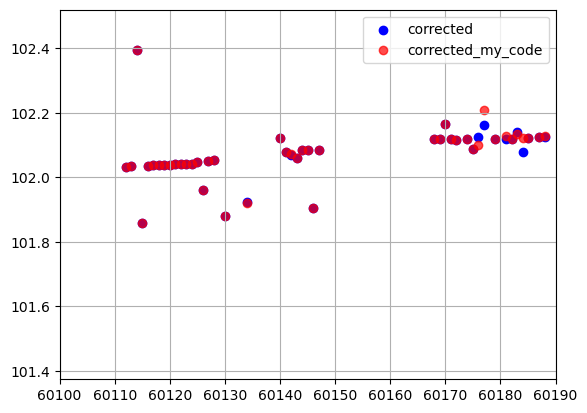

In [89]:
plt.scatter(date+40000,freq,label='corrected',c='b')
plt.grid()
plt.scatter(date2+40000,freq2,label="corrected_my_code",c='r',alpha=0.7)
plt.xlim(60100,60190)
#plt.ylim(102.01,102.3)
plt.legend()

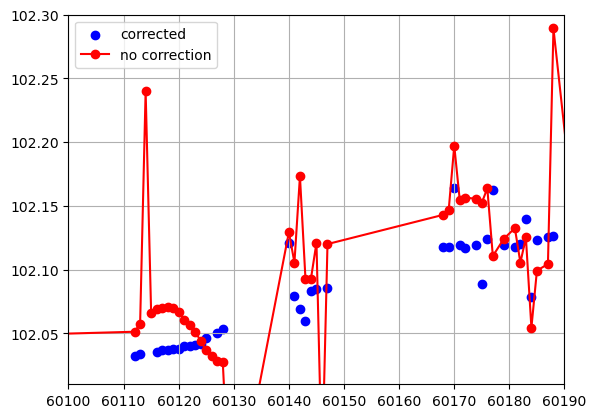

In [92]:
plt.scatter(date+40000,freq,label='corrected',c='b')
plt.grid()
plt.plot(date1+40000,freq1,"-o",label="no correction",c='r')
plt.xlim(60100,60190)
plt.ylim(102.01,102.3)
plt.legend()

Text(0.5, 1.0, 'NICER frequency vs MJD variation')

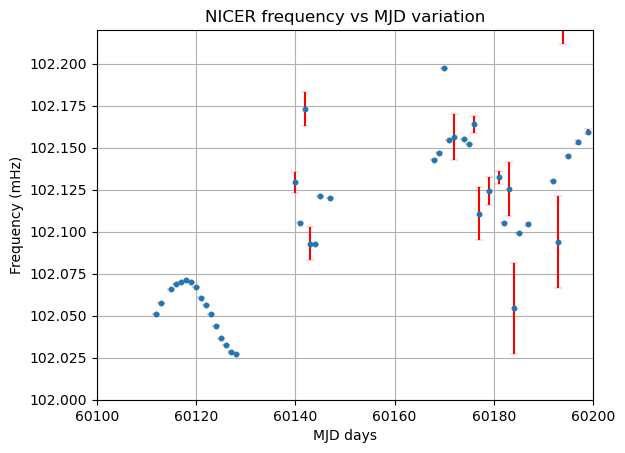

In [84]:
plt.errorbar(date1+40000,freq1,yerr=freqerr1,fmt='o', ecolor='r', capsize=3, markersize=4,markeredgewidth=0.2)
plt.xlim(60100,60200)
plt.ylim(102,102.22)
plt.grid()
plt.xlabel('MJD days')
plt.ylabel('Frequency (mHz)')
plt.title('NICER frequency vs MJD variation')

## Trying to fit and find orbit

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares

In [193]:
df=pd.read_csv('all_lc_periods_lc_files_bary.txt',sep='\t')
df_sorted = df.sort_values(by='TSTARTI')
date=df_sorted[df_sorted['TSTARTI']>=20100]['TSTARTI'].reset_index(drop=True)
period=df_sorted[df_sorted['TSTARTI']>=20100]['Period'].reset_index(drop=True)

Fitted parameters: f0 = 102.021734 Hz, fdot = 2.797413e-08 Hz/s, fddot = -4.200971e-15 Hz/s², t0 = 0.00 s
Chi-square: 215182217687.77, Degrees of Freedom: 49, Reduced Chi-square: 4391473830.36


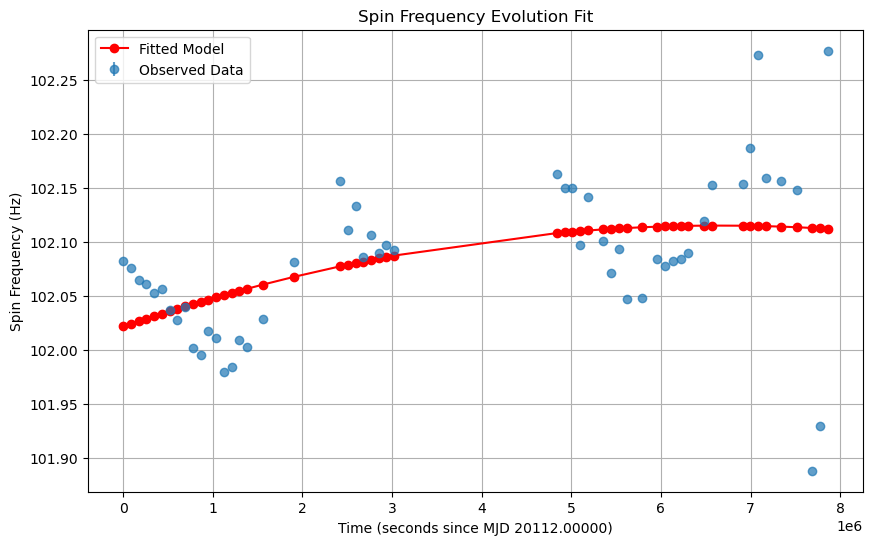

In [194]:
# Define the intrinsic spin frequency evolution model
def f_spin(t, f0, fdot, fddot, t0):
    return f0 + fdot * (t - t0) + 0.5 * fddot * (t - t0)**2

# Function to calculate the reduced chi-square statistic
def reduced_chi_square(observed, expected, errors, num_params):
    residuals = observed - expected
    chi_square = np.sum((residuals / errors)**2)
    degrees_of_freedom = len(observed) - num_params
    reduced_chi2 = chi_square / degrees_of_freedom
    return reduced_chi2, chi_square, degrees_of_freedom

# Load your data here
mjd_array = date  # Your MJD time values
period_array = period  # Your spin period values in seconds

# Convert periods to frequencies
frequency_array = 1000 / period_array  # Convert period (P) to frequency (f = 1/P)

# Convert MJD to seconds relative to some reference MJD (e.g., the first observation)
mjd_ref = mjd_array[0]
t_data = (mjd_array - mjd_ref) * 86400  # Convert MJD to seconds

# Assume constant error for frequencies (adjust this as needed)
freq_errors = np.full_like(frequency_array, 1e-6)  # Example error value, adjust as per your data

# Fit the model to the data using curve_fit
initial_guess = [frequency_array[0], -1e-10, 1e-20, t_data[0]]
try:
    popt, pcov = curve_fit(f_spin, t_data, frequency_array, p0=initial_guess, sigma=freq_errors, absolute_sigma=True)
except RuntimeError as e:
    print("Error during curve fitting:", e)
    popt = None

# Extract fitted parameters if fit was successful
if popt is not None:
    f0_fit, fdot_fit, fddot_fit, t0_fit = popt
    print(f"Fitted parameters: f0 = {f0_fit:.6f} Hz, fdot = {fdot_fit:.6e} Hz/s, fddot = {fddot_fit:.6e} Hz/s², t0 = {t0_fit:.2f} s")

    # Generate fitted frequency data using the fitted parameters
    f_fitspinup = f_spin(t_data, f0_fit, fdot_fit, fddot_fit, t0_fit)

    # Calculate the reduced chi-square statistic
    chi2_reduced, chi2, dof = reduced_chi_square(frequency_array, f_fitspinup, freq_errors, len(popt))
    print(f"Chi-square: {chi2:.2f}, Degrees of Freedom: {dof}, Reduced Chi-square: {chi2_reduced:.2f}")

    # Plot the observed data and the fitted model
    plt.figure(figsize=(10, 6))
    plt.errorbar(t_data, frequency_array, yerr=freq_errors, fmt='o', label='Observed Data', alpha=0.7)
    plt.plot(t_data, f_fitspinup, '-o',label='Fitted Model', color='red')
    plt.xlabel('Time (seconds since MJD {:.5f})'.format(mjd_ref))
    plt.ylabel('Spin Frequency (Hz)')
    plt.title('Spin Frequency Evolution Fit')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Fit was not successful. Please check your data and initial guesses.")

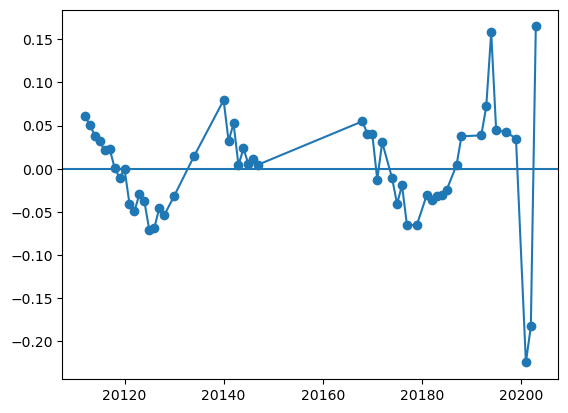

In [195]:
## Plotting residuals
residuals=frequency_array-f_fitspinup
plt.plot(mjd_array,residuals,'-o')
plt.axhline(0)

In [196]:
# Define the detailed model function with spin-up and Doppler shift terms
def full_frequency_model(t, f0, fdot, fddot, t0, a_sin_i, P_orb, e, omega, T_pi2):
    # Calculate the intrinsic spin frequency evolution
    f_spin = f0 + fdot * (t - t0) + 0.5 * fddot * (t - t0)**2

    # Calculate the Doppler shift terms
    g = e * np.sin(omega)
    h = e * np.cos(omega)
    
    # Calculate mean longitude l
    l = (2 * np.pi * (t - T_pi2) / P_orb) + np.pi / 2

    # Doppler shift component
    doppler_shift = (2 * np.pi * f0 * a_sin_i / P_orb) * (np.cos(l) + g * np.sin(2 * l) + h * np.cos(2 * l))
    
    # Total frequency model
    return f_spin - doppler_shift
    #return doppler_shift

# Define a function to calculate the reduced chi-square
def reduced_chi_square(observed, expected, errors, num_params):
    residuals = observed - expected
    chi_square = np.sum((residuals / errors)**2)
    degrees_of_freedom = len(observed) - num_params
    reduced_chi2 = chi_square / degrees_of_freedom
    return reduced_chi2, chi_square, degrees_of_freedom

Fitted parameters:
f0 = 102.019985 Hz
fdot = 3.396032e-08 Hz/s
fddot = -5.898099e-15 Hz/s²
a_sin_i = 206.668 lt-s
P_orb = 26.53734 days
e = -0.2010
omega = -6.0610 rad
T_pi2 = -837391812.57 s
Chi-square: 123170.76, Degrees of Freedom: 44, Reduced Chi-square: 2799.34


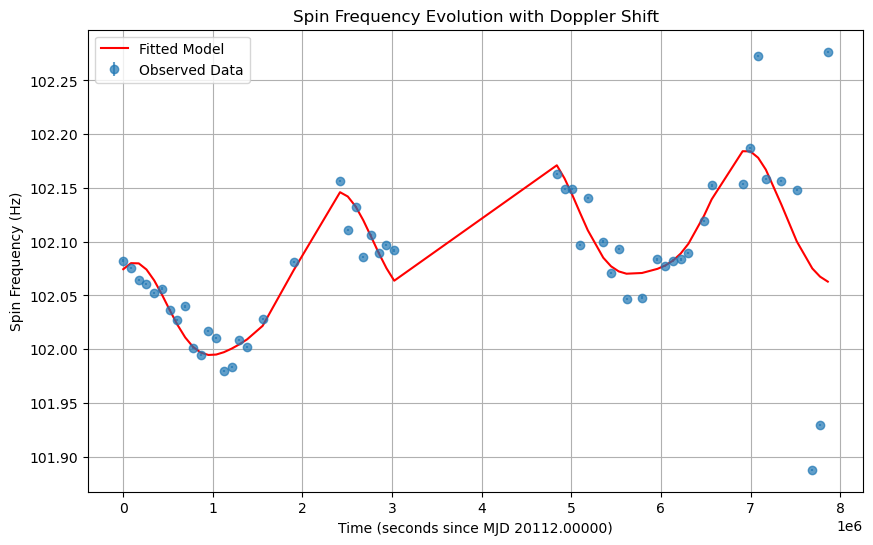

In [197]:
# Load your data here
mjd_array = date  # Your MJD time values
period_array = period  # Your spin period values in seconds

# Convert periods to frequencies
frequency_array = 1000 / period_array  # Convert period (P) to frequency (f = 1/P)

# Convert MJD to seconds relative to some reference MJD (e.g., the first observation)
mjd_ref = mjd_array[0]
t_data = (mjd_array - mjd_ref) * 86400  # Convert MJD to seconds

# Assume constant error for frequencies (adjust this as needed)
freq_errors = np.full_like(frequency_array, 1e-3)  # Example error value, adjust based on your data

# Define initial guesses for the fit
initial_guess = [
    frequency_array[0],   # f0 (initial frequency in Hz)
    2.507265e-08,         # fdot (frequency derivative)
    -3.725352e-15,        # fddot (second frequency derivative)
    t_data[0],            # t0 (reference time)
    115.531,              # a_sin_i (projected semi-major axis in light-seconds)
    27.6943 * 86400,      # P_orb (orbital period in seconds, use your own value)
    0.1029,               # e (eccentricity)
    -1.2924163111,        # omega (argument of periastron in radians)
    -874022400           # T_pi2 (time of pi/2 in seconds)
]

# Bounds for parameters to prevent unphysical values
lower_bounds = [100.0, -1e-6, -1e-14, 50.0, 20 * 86400, 0.0, 0.0, -1e7, t_data[0] - 1e6]
upper_bounds = [105.0, 1e-6, 1e-14, 400.0, 30 * 86400, 0.9, 2 * np.pi, 1e7, t_data[0] + 1e6]


# Fit the model to the data using curve_fit
try:
    popt, pcov = curve_fit(
        full_frequency_model, t_data, frequency_array, p0=initial_guess, sigma=freq_errors, absolute_sigma=True
    )
except RuntimeError as e:
    print("Error during curve fitting:", e)
    popt = None

# Extract and display the fitted parameters
if popt is not None:
    f0_fit, fdot_fit, fddot_fit, t0_fit, a_sin_i_fit, P_orb_fit, e_fit, omega_fit, T_pi2_fit = popt
    print(f"Fitted parameters:")
    print(f"f0 = {f0_fit:.6f} Hz")
    print(f"fdot = {fdot_fit:.6e} Hz/s")
    print(f"fddot = {fddot_fit:.6e} Hz/s²")
    print(f"a_sin_i = {a_sin_i_fit:.3f} lt-s")
    print(f"P_orb = {P_orb_fit / 86400:.5f} days")
    print(f"e = {e_fit:.4f}")
    print(f"omega = {omega_fit:.4f} rad")
    print(f"T_pi2 = {T_pi2_fit:.2f} s")

    # Generate fitted frequency data using the fitted parameters
    f_fit = full_frequency_model(t_data, *popt)

    # Calculate the reduced chi-square statistic
    chi2_reduced, chi2, dof = reduced_chi_square(frequency_array, f_fit, freq_errors, len(popt))
    print(f"Chi-square: {chi2:.2f}, Degrees of Freedom: {dof}, Reduced Chi-square: {chi2_reduced:.2f}")

    # Plot the observed data and the fitted model
    plt.figure(figsize=(10, 6))
    plt.errorbar(t_data, frequency_array, yerr=freq_errors, fmt='o', label='Observed Data', alpha=0.7)
    plt.plot(t_data, f_fit, label='Fitted Model', color='red')
    plt.xlabel('Time (seconds since MJD {:.5f})'.format(mjd_ref))
    plt.ylabel('Spin Frequency (Hz)')
    plt.title('Spin Frequency Evolution with Doppler Shift')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Fit was not successful. Please check your data and initial guesses.")

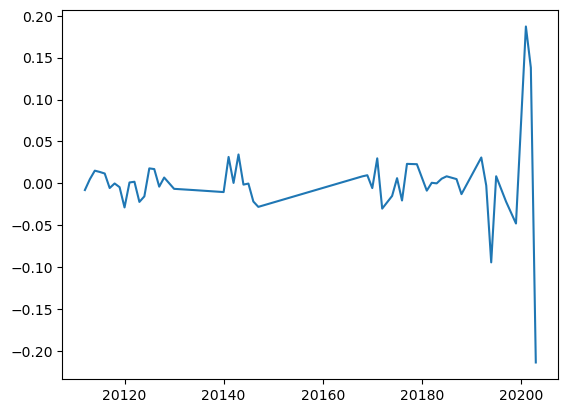

In [198]:
residuals=f_fit-frequency_array
plt.plot(date, residuals)

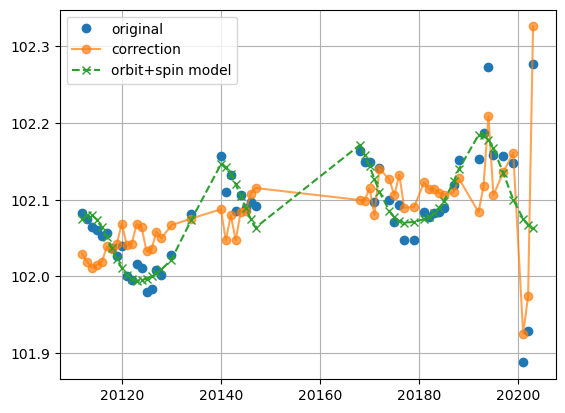

In [199]:
plt.plot(mjd_array,frequency_array,'o',label='original')
plt.plot(mjd_array,(frequency_array-f_fit+f_fitspinup),'-o',label='correction',alpha=0.7)
plt.plot(mjd_array,(f_fit),'--x',label='orbit+spin model')
#plt.plot(mjd_array,(f_fitspinup),'-',label='spin up model')
plt.grid()
plt.legend()

## Predicting due to orbital

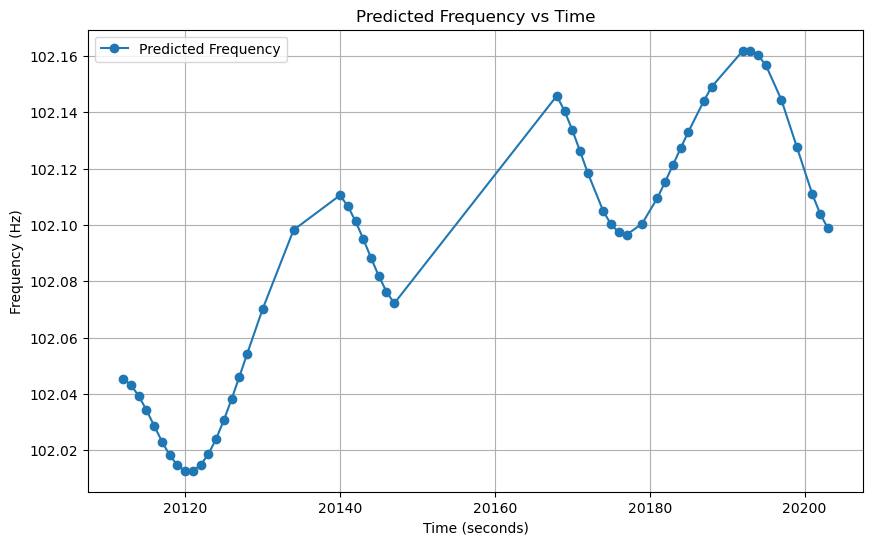

In [221]:
import numpy as np
import matplotlib.pyplot as plt

# Define the detailed model function with spin-up and Doppler shift terms
def full_frequency_model(t, f0, fdot, fddot, t0, a_sin_i, P_orb, e, omega, T_pi2):
    """
    Calculate the observed frequency as a function of time including spin evolution and Doppler shift effects.
    
    Parameters:
    t      : numpy array, observation times (in seconds)
    f0     : float, intrinsic spin frequency at reference time t0 (Hz)
    fdot   : float, first derivative of frequency (Hz/s)
    fddot  : float, second derivative of frequency (Hz/s^2)
    t0     : float, reference time (in seconds)
    a_sin_i: float, projected semi-major axis of the orbit (in light-seconds)
    P_orb  : float, orbital period (in seconds)
    e      : float, orbital eccentricity
    omega  : float, longitude of periastron (in radians)
    T_pi2  : float, time of ascending node passage (in seconds)

    Returns:
    numpy array of predicted frequencies (in Hz).
    """
    # Calculate the intrinsic spin frequency evolution
    f_spin = f0 + fdot * (t - t0) + 0.5 * fddot * (t - t0)**2

    # Calculate the Doppler shift terms
    g = e * np.sin(omega)
    h = e * np.cos(omega)
    
    # Calculate mean longitude l
    l = (2 * np.pi * (t - T_pi2) / P_orb) + np.pi / 2

    # Doppler shift component
    doppler_shift = (2 * np.pi * f0 * a_sin_i / P_orb) * (np.cos(l) + g * np.sin(2 * l) + h * np.cos(2 * l))
    
    # Total frequency model
    return f_spin - doppler_shift


# === Input parameters (Adjust these according to your data) ===
f0 = 102.019985           # Spin frequency in Hz
fdot = 3.358043e-8          # Spin frequency derivative in Hz/s
fddot = -5.055761e-15       # Second derivative of spin frequency in Hz/s²
a_sin_i = 115.531           # Projected semi-major axis in light-seconds
P_orb = 27.6943 * 86400    # Orbital period in seconds (converted from days)
e = 0.1029                 # Orbital eccentricity
omega = -1.2924            # Longitude of periastron in radians

# Convert T_pi2 from TJD to seconds
T_pi2_TJD=0
T_pi2 = T_pi2_TJD * 86400   # Convert to seconds

# Reference time for spin evolution (using T_pi2 as reference)

# === Input your own time array (in TJD) ===
t_data_seconds = (mjd_array - 10116.097+12) * 86400  # Convert MJD to seconds # Convert TJD to seconds
t0 = t_data_seconds[0]

# === Calculate predicted frequency ===
predicted_frequency = full_frequency_model(t_data_seconds, f0, fdot, fddot, t0, a_sin_i, P_orb, e, omega, T_pi2)

# === Optional: Plotting the results ===
plt.figure(figsize=(10, 6))
plt.plot(mjd_array, predicted_frequency, 'o-', label='Predicted Frequency')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Predicted Frequency vs Time')
plt.grid(True)
plt.legend()
plt.show()

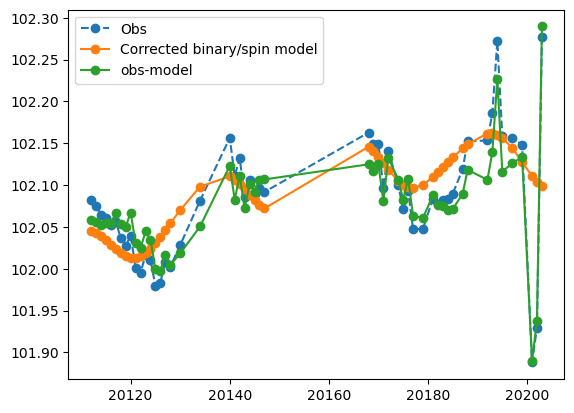

In [ ]:
plt.plot(mjd_array,frequency_array,'--o',label='Obs')
#plt.plot(mjd_array,(f_fit),'-o')
#plt.plot(mjd_array,(f_fitspinup),'-o')
plt.plot(mjd_array,predicted_frequency,'-o',label='Corrected binary/spin model')
#plt.plot(mjd_array,(frequency_array-predicted_frequency+f_fitspinup),'-o',label='obs-model')
plt.legend()